# Data processing

In [4]:
import os
import pandas as pd
import requests
from zipfile import ZipFile
from io import BytesIO

In [2]:
# download the datafiles
# base_url = "https://s3.amazonaws.com/capitalbikeshare-data/"

# data_dir = './data'
# os.makedirs(data_dir, exist_ok=True)

# # download 202301-202401 data
# year_months = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', 
#                '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01']

# for year_month in year_months:
#     file_name = f"{year_month.replace('-', '')}-capitalbikeshare-tripdata.zip"
#     url = base_url + file_name
    
#     # Attempt to download the file
#     try:
#         print(f"Downloading {file_name}...")
#         response = requests.get(url)
#         if response.status_code == 200:
#             # If download is successful, read the zip file
#             with ZipFile(BytesIO(response.content)) as thezip:
#                 # Extract only the CSV file directly into the 'data' directory
#                 for member in thezip.namelist():
#                     if member.endswith('.csv'):
#                         # Define the path to save the CSV file
#                         csv_path = os.path.join(data_dir, member)
#                         # Extract the CSV file
#                         with open(csv_path, 'wb') as f:
#                             f.write(thezip.read(member))
#                         print(f"Successfully downloaded and extracted {member} into {data_dir}")
#         else:
#             print(f"Failed to download {file_name}. Status code: {response.status_code}")
#     except Exception as e:
#         print(f"An error occurred while downloading {file_name}: {e}")

In [3]:
# concat all datafiles and read-in as dataframe
dfs = []

for filename in os.listdir('./data'):
    if filename.endswith('.csv'):
        file_path = os.path.join('./data', filename)
        # Read the CSV file and append it to the list of DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5F3D280238A782FE,docked_bike,2023-05-12 18:57:59,2023-05-12 19:17:50,3rd & Tingey St SE,31634.0,8th & F St NE,31631.0,38.875010,-77.002400,38.897274,-76.994749,casual
1,97EC218DACB24849,classic_bike,2023-05-23 07:55:29,2023-05-23 08:11:12,Clarendon Blvd & Pierce St,31016.0,15th & L St NW,31276.0,38.893438,-77.076389,38.903649,-77.034918,member
2,31D19AC7BA317018,electric_bike,2023-05-05 17:27:10,2023-05-05 17:40:17,South Capitol St and Southern Ave SE,31830.0,Tanger Outlets,32415.0,38.821667,-77.001627,38.796800,-77.002600,member
3,18064EB7133720BF,classic_bike,2023-05-09 11:22:05,2023-05-09 11:35:11,11th & O St NW,31286.0,19th St & Pennsylvania Ave NW,31100.0,38.908431,-77.027088,38.900300,-77.042900,member
4,02E47B545236B208,classic_bike,2023-05-06 10:24:09,2023-05-06 10:35:13,11th & O St NW,31286.0,16th & Harvard St NW,31135.0,38.908431,-77.027088,38.926102,-77.036650,casual


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706168 entries, 0 to 4706167
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    float64
 6   end_station_name    object 
 7   end_station_id      float64
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(6), object(7)
memory usage: 466.8+ MB


In [6]:
# data processing
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration_minutes'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

df['year'] = df['started_at'].dt.year
df['month'] = df['started_at'].dt.month
df['day'] = df['started_at'].dt.date

In [7]:
# Node data: 
# Step 1: calculate daily unique rider and daily average ride duration
daily_df = df.pivot_table(
    index=['year', 'month', 'day', 'start_station_id', 'rideable_type', 'member_casual'],
    values=['ride_id', 'duration_minutes'],
    aggfunc={'ride_id': pd.Series.nunique, 'duration_minutes': 'mean'}
).reset_index().rename(columns={'ride_id': 'daily_unique_riders'})

In [8]:
daily_df

,year,month,day,start_station_id,rideable_type,member_casual,duration_minutes,daily_unique_riders
0,2023,1,2023-01-01,31000.0,classic_bike,casual,29.850000,4
1,2023,1,2023-01-01,31000.0,classic_bike,member,27.033333,2
2,2023,1,2023-01-01,31002.0,classic_bike,casual,12.600000,2
3,2023,1,2023-01-01,31002.0,classic_bike,member,13.045833,4
4,2023,1,2023-01-01,31003.0,classic_bike,casual,17.866667,1
...,...,...,...,...,...,...,...,...
682171,2024,1,2024-01-31,32609.0,electric_bike,casual,12.183333,1
682172,2024,1,2024-01-31,32609.0,electric_bike,member,3.916667,1
682173,2024,1,2024-01-31,33200.0,classic_bike,casual,8.372222,3
682174,2024,1,2024-01-31,33200.0,classic_bike,member,14.086667,5


In [9]:
# Step 2: Aggregate monthly metrics for each station, rideable type, and member/casual status
station_metrics = daily_df.pivot_table(
    index=['year', 'month', 'start_station_id', 'rideable_type', 'member_casual'],
    values=['daily_unique_riders', 'duration_minutes'],
    aggfunc={
        'daily_unique_riders': ['mean'],  # Daily average unique riders
        'duration_minutes': ['sum', 'mean']  # Daily average duration
    }
)

station_metrics.reset_index(inplace=True)

In [10]:
# station_metrics.to_csv("processed_data/node_attributes_file.csv", index = False)

In [11]:
# Edge data: 
edges_df = df.pivot_table(index=['year', 'month', 'start_station_id', 'end_station_id', 'rideable_type', 'member_casual'], 
                          aggfunc='size',
                          fill_value=0).reset_index(name='trip_count')

In [12]:
# edges_df.to_csv("processed_data/edge_file.csv", index = False)

In [13]:
# geo data:
start_stations = df[['start_station_id', 'start_lat', 'start_lng']].rename(
    columns={'start_station_id': 'station_id', 'start_lat': 'lat', 'start_lng': 'lng'}
)
end_stations = df[['end_station_id', 'end_lat', 'end_lng']].rename(
    columns={'end_station_id': 'station_id', 'end_lat': 'lat', 'end_lng': 'lng'}
)
all_stations = pd.concat([start_stations, end_stations], ignore_index=True)
stations_geo_df = all_stations.drop_duplicates(subset=['station_id'])

# stations_geo_df.to_csv("processed_data/stations_geo.csv", index = False)

# EDA

In [1]:
!pip install folium

In [7]:
node_df = pd.read_csv("processed_data/node_attributes_file.csv")
edges_df = pd.read_csv("processed_data/edge_file.csv")
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")

In [5]:
import folium

map_center_lat = stations_geo_df['lat'].mean()
map_center_lng = stations_geo_df['lng'].mean()
m = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=13)

for _, row in stations_geo_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        icon=folium.Icon(color='green'),
        popup=f"Station: {row['station_id']}",
    ).add_to(m)

In [6]:
m

In [8]:
# Visualisation

import matplotlib.pyplot as plt

In [13]:
edges_df['year-month'] = pd.to_datetime(edges_df['year'].astype('str') + '-' + edges_df['month'].astype('str'))

trip_counts_pivot = edges_df[['year-month', 'rideable_type', 'trip_count']].pivot_table(
    index='year-month', 
    columns='rideable_type', 
    aggfunc='sum', 
    fill_value=0
)

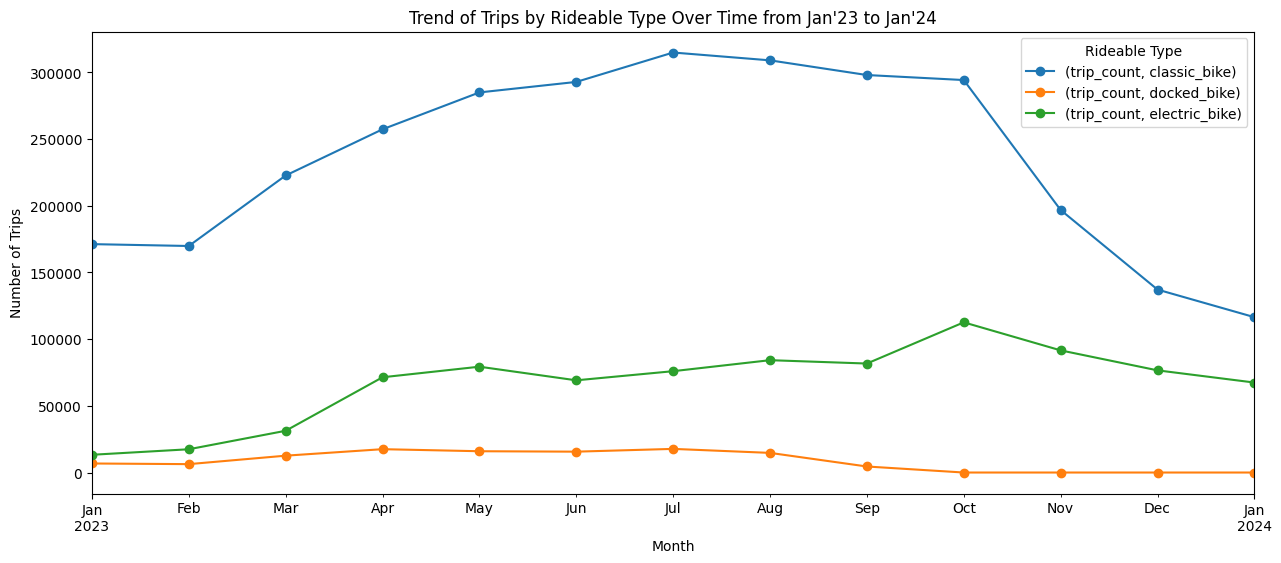

In [27]:
trip_counts_pivot.plot(kind='line', marker='o', figsize=(15, 6))
plt.title("Trend of Trips by Rideable Type Over Time from Jan'23 to Jan'24")
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.legend(title='Rideable Type', loc='upper right')
plt.show()

In [28]:
trip_counts_pivot2 = edges_df[['year-month', 'member_casual', 'trip_count']].pivot_table(
    index='year-month', 
    columns='member_casual', 
    aggfunc='sum', 
    fill_value=0
)

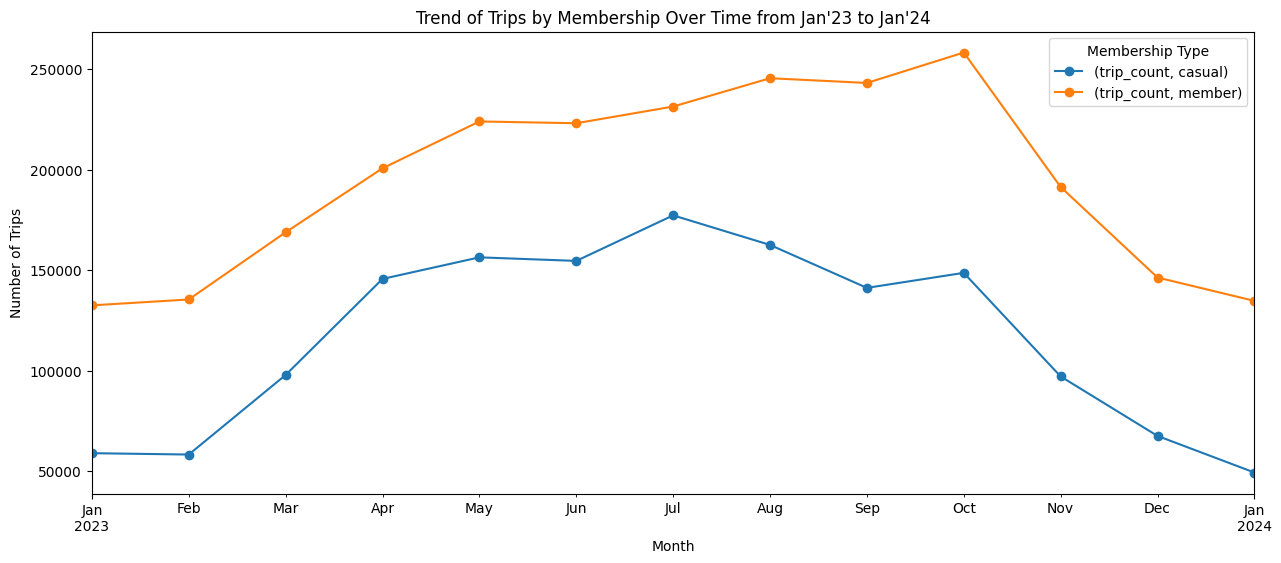

In [29]:
trip_counts_pivot2.plot(kind='line', marker='o', figsize=(15, 6))
plt.title("Trend of Trips by Membership Over Time from Jan'23 to Jan'24")
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.legend(title='Membership Type', loc='upper right')
plt.show()

# Task 1: Network Resilience

### 1.1: Construct a network


*   Node: stations
*   Edge: trips between these stations
*   Edge weights: volume of trips

### 1.2:
Implement the two types of node deletion strategies on your network, and plot the associated changes in average shortest path length (i.e., average distance) & diameter as a function of the fraction of nodes removed. Do the resulting plots resemble the Fig. 2 on Pg. 12 of the Albert et al. (2000) paper above? Why do you (/don’t you) see this pattern?

### 1.3
Can you think of any other important graph-level metric, apart from average distance or diameter, that can potentially measure structural resilience of the network to such errors and attacks? Compute this metric, and test if this metric also shows significant variation in response to these two types of node deletions.

### 1.4
Repeat the above set of analyses for the network over time (e.g., for each month or quarter or year). Do you see any change in the resilience of the network over time? What patterns (if any) do you see from this temporal analysis?